In [1]:
import pandas as pd
from sklearn import svm
import pickle

C:\Users\assas\AppData\Local\Temp\ipykernel_14452\2319727694.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
train = pd.read_csv('train.csv')
valid = pd.read_csv('valid.csv')

In [10]:
train.drop(train[(train['mean_slope'] == "--") | (train['std_slope'] == "--")].index, inplace=True)
valid.drop(valid[(valid['mean_slope'] == "--") | (valid['std_slope'] == "--")].index, inplace=True)



In [11]:
X_train = train.drop(columns=['image_file', 'label'])
y_train = train['label']

X_valid = valid.drop(columns=['image_file', 'label'])
y_valid = valid['label']

In [12]:
from numpy import mean
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, cross_val_score



model = svm.SVC(gamma='scale')

param_grid = {
    'class_weight': ({0:1, 1:2}, {0:1,1:4}, {0:1,1:5}),
    'kernel': ('rbf', 'sigmoid'),
    'C': (2, 3),
    'degree': (2, 3)
}
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='f1')

grid_result = grid.fit(X_train, y_train)

# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.984699 using {'C': 3, 'class_weight': {0: 1, 1: 2}, 'degree': 2, 'kernel': 'rbf'}
0.981048 (0.007811) with: {'C': 2, 'class_weight': {0: 1, 1: 2}, 'degree': 2, 'kernel': 'rbf'}
0.955312 (0.003066) with: {'C': 2, 'class_weight': {0: 1, 1: 2}, 'degree': 2, 'kernel': 'sigmoid'}
0.981048 (0.007811) with: {'C': 2, 'class_weight': {0: 1, 1: 2}, 'degree': 3, 'kernel': 'rbf'}
0.955312 (0.003066) with: {'C': 2, 'class_weight': {0: 1, 1: 2}, 'degree': 3, 'kernel': 'sigmoid'}
0.980134 (0.007527) with: {'C': 2, 'class_weight': {0: 1, 1: 4}, 'degree': 2, 'kernel': 'rbf'}
0.953869 (0.002524) with: {'C': 2, 'class_weight': {0: 1, 1: 4}, 'degree': 2, 'kernel': 'sigmoid'}
0.980134 (0.007527) with: {'C': 2, 'class_weight': {0: 1, 1: 4}, 'degree': 3, 'kernel': 'rbf'}
0.953869 (0.002524) with: {'C': 2, 'class_weight': {0: 1, 1: 4}, 'degree': 3, 'kernel': 'sigmoid'}
0.980134 (0.007527) with: {'C': 2, 'class_weight': {0: 1, 1: 5}, 'degree': 2, 'kernel': 'rbf'}
0.953869 (0.002524) with: {'C': 2, 'cla

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.64      0.78        11
           1       0.97      1.00      0.98       120

    accuracy                           0.97       131
   macro avg       0.98      0.82      0.88       131
weighted avg       0.97      0.97      0.97       131

Confusion Matrix:


<Axes: >

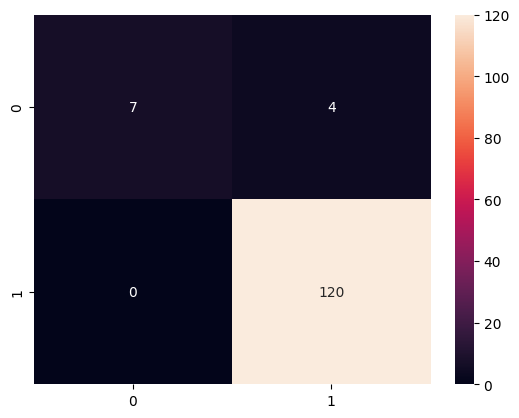

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
weigths = grid_result.best_params_['class_weight']
model = svm.SVC(gamma='scale', class_weight=weigths)
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)

print("Classification Report:")
print(classification_report(y_valid, y_pred))
print("Confusion Matrix:")
sns.heatmap(confusion_matrix(y_valid,y_pred),annot = True,fmt='d')


In [15]:
s = pickle.dump(model, open('./models/svc.pkl', 'wb'))

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from sklearn.metrics import classification_report

# Define the model architecture
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC', 'Precision', 'Recall'])
callback = EarlyStopping(monitor='AUC', patience=3)
# Fit the model to the training data
model.fit(np.asarray(X_train).astype('float32'), np.asarray(y_train).astype('float32'), epochs=30, batch_size=64, class_weight={0: 1, 1: 4}, callbacks=[callback])

Epoch 1/30
19/19 [==============================] - 1s 9ms/step - loss: 1.2751 - accuracy: 0.8725 - auc: 0.6024 - precision: 0.9301 - recall: 0.9301
Epoch 2/30
19/19 [==============================] - 0s 9ms/step - loss: 0.4839 - accuracy: 0.9165 - auc: 0.8672 - precision: 0.9478 - recall: 0.9612
Epoch 3/30
19/19 [==============================] - 0s 8ms/step - loss: 0.1911 - accuracy: 0.9638 - auc: 0.9497 - precision: 0.9618 - recall: 1.0000
Epoch 4/30
19/19 [==============================] - 0s 8ms/step - loss: 0.0884 - accuracy: 0.9811 - auc: 0.9847 - precision: 0.9796 - recall: 1.0000
Epoch 5/30
19/19 [==============================] - 0s 8ms/step - loss: 0.0533 - accuracy: 0.9931 - auc: 0.9981 - precision: 0.9925 - recall: 1.0000
Epoch 6/30
19/19 [==============================] - 0s 8ms/step - loss: 0.0306 - accuracy: 0.9948 - auc: 0.9999 - precision: 0.9944 - recall: 1.0000
Epoch 7/30
19/19 [==============================] - 0s 8ms/step - loss: 0.0238 - accuracy: 0.9948 - auc: 1

In [29]:
# Predict on the test data
y_pred = model.predict(np.asarray(X_valid).astype('float32'))

# Convert predictions to binary labels
y_pred_binary = np.round(y_pred)

# Generate classification report
report = classification_report(np.asarray(y_valid).astype('float32'), y_pred_binary)
print("Classification Report:")
print(report)

5/5 [==============================] - 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        11
         1.0       1.00      1.00      1.00       120

    accuracy                           1.00       131
   macro avg       1.00      1.00      1.00       131
weighted avg       1.00      1.00      1.00       131



<Axes: >

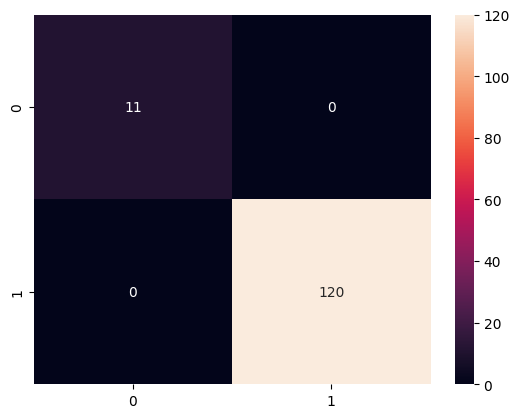

In [31]:
sns.heatmap(confusion_matrix(y_valid,y_pred_binary),annot = True,fmt='d')

In [32]:
model.save('./models/nn.h5')

In [33]:
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'criterion': ('gini', 'entropy'),
    'splitter': ('best', 'random'),
    'max_depth': (None, 10, 20, 30)
}
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
model = DecisionTreeClassifier()
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='f1')

grid_result = grid.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_ , grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 1.000000 using {'criterion': 'gini', 'max_depth': 20, 'splitter': 'random'}
0.999684 (0.001182) with: {'criterion': 'gini', 'max_depth': None, 'splitter': 'best'}
0.999365 (0.001619) with: {'criterion': 'gini', 'max_depth': None, 'splitter': 'random'}
0.999684 (0.001182) with: {'criterion': 'gini', 'max_depth': 10, 'splitter': 'best'}
0.999525 (0.001426) with: {'criterion': 'gini', 'max_depth': 10, 'splitter': 'random'}
0.999684 (0.001182) with: {'criterion': 'gini', 'max_depth': 20, 'splitter': 'best'}
1.000000 (0.000000) with: {'criterion': 'gini', 'max_depth': 20, 'splitter': 'random'}
0.999684 (0.001182) with: {'criterion': 'gini', 'max_depth': 30, 'splitter': 'best'}
0.999842 (0.000851) with: {'criterion': 'gini', 'max_depth': 30, 'splitter': 'random'}
0.999684 (0.001182) with: {'criterion': 'entropy', 'max_depth': None, 'splitter': 'best'}
0.999683 (0.001188) with: {'criterion': 'entropy', 'max_depth': None, 'splitter': 'random'}
0.999526 (0.001422) with: {'criterion': 'ent

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00       120

    accuracy                           1.00       131
   macro avg       1.00      1.00      1.00       131
weighted avg       1.00      1.00      1.00       131

Confusion Matrix:


<Axes: >

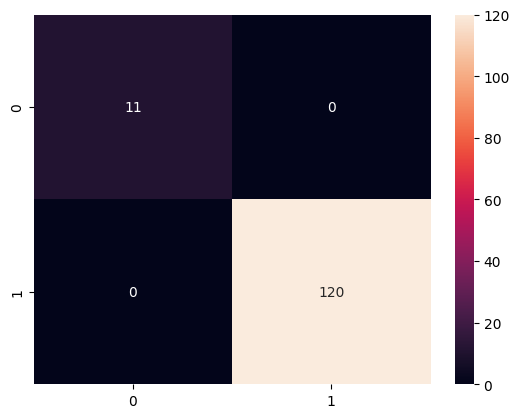

In [34]:
model = DecisionTreeClassifier(criterion='entropy', max_depth=20, splitter='random')
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)

print("Classification Report:")
print(classification_report(y_valid, y_pred))

print("Confusion Matrix:")
sns.heatmap(confusion_matrix(y_valid,y_pred),annot = True,fmt='d')

In [41]:
pickle.dump(model, open('./models/dt.pkl', 'wb'))